<a href="https://colab.research.google.com/github/monta0315/DGM-and-VR/blob/main/VR/VR3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#画像認識第3回　Human pose estimation 


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os 

path = '/content/drive/MyDrive/画像認識/第3回 のコピー/HPE'
os.chdir(path)
print(os.getcwd())

import tqdm
import torch
from torch import nn
from torch.nn import DataParallel

from utils_file import reload,save
from data.MPII import dp

/content/drive/.shortcut-targets-by-id/1Z-IiEcuchG-2tbgbkEDbDqkYBHRmOjbS/HPE


In [7]:
#必要なパラメータ類をconfigで定義しておく
#本実装では必要なパラメータや保存ディレクトリなどを一括でconfigに格納している

config = {  

    'inference': {
        'nstack': 2,
        'inp_dim': 256,
        'oup_dim': 16,
        'num_parts': 16,
    },
    
    'train': {
        'batchsize': 8,
        'input_res': 256,
        'output_res': 64,
        'train_iters': 100,
        'valid_iters': 10,
        'learning_rate': 1e-3,
        'num_workers': 2,
    },
}


## 1. Stacked Hourglass Networks のモデルの実装

まず、HPEにおいて広く使われているCNNモデルのStack Hourglass Networksの実装を行う。

Stack Hourglass Networksは下図が示す様にEncoderとDecoderが多層に積みあがった構造をしており、一つ一つのEncoder + DecoderをHourglass Networkと呼ぶ。

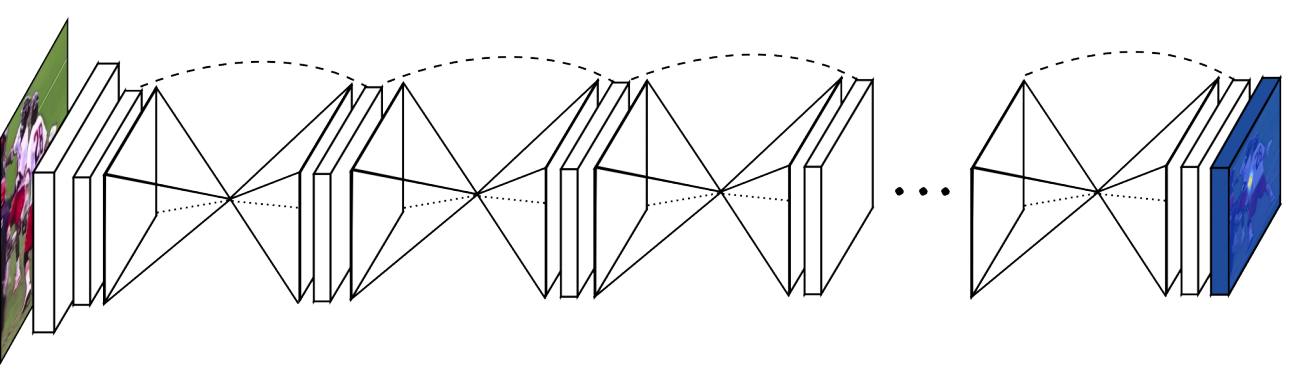

実装は以下の4段階に分けて行うこととする。

1. Conv層 + Norm層 + 活性化関数を纏めた「Conv」クラス
2. Convクラスなどを用いてResidual Blockを定義する「Residual」クラス
3. Residual BlockをベースにしてHourglass Networkを定義する「Hourglass」クラス
4. Hourglass Networkを多段に積み重ねてStacked Hourglass Networksを定義する「PoseNet」クラス

#1-1 Convクラスの実装
畳み込み層、Batch Norimalization層、､活性化関数(ReLU)をまとめて定義するクラスを作成
Batch Normalization層とReLU層はON/OFFをコントロールできるようにする

In [8]:
class Conv(nn.Module):
    def __init__(self,inp_dim,out_dim,kernel_size=3,stride=1,bn=False,relu=True):
        super(Conv,self).__init__()
        self.inp_dim = inp_dim
        self.conv = nn.Conv2d(inp_dim,out_dim,kernel_size,stride,padding=(kernel_size-1)//2,bias=True)
        self.relu = None
        self.bn = None
        if relu:
            self.relu = nn.ReLU()
        if bn:
            self.bn = nn.BatchNorm2d(out_dim)
    
    def forward(self,x):
        assert x.size()[1] == self.inp_dim,"{} {}".format(x.size()[1],self.inp_dim)
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

#1-2 Residualクラスの定義

Hourglass NetworkはResNetにも使われているResidual Blockをベースに構成されているので、ここではResidual Blockを定義するクラスであるResidualクラスを定義する

また、Residual Blockの中でも一旦1x1のConvで特徴マップ数を半分に減らしてから3x3のconvによる演算を行い、また、1x1のconvで特徴マップ数を元に戻すBottoleneck Blockを用いている（パラメータ数の削減に有効）

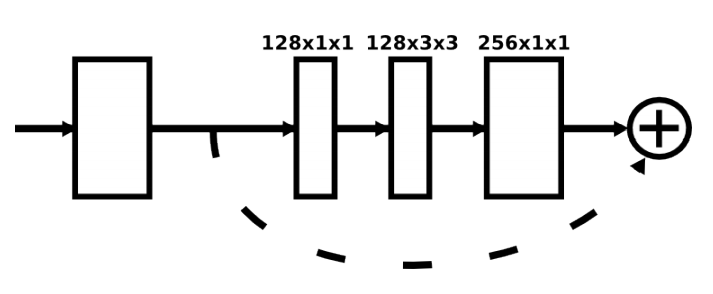

In [9]:
class Residual(nn.Module):
    def __init__(self,inp_dim,out_dim):
        super(Residual,self).__init__()
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(inp_dim)
        self.conv1 = Conv(inp_dim,int(out_dim/2),1,relu=False)
        self.bn2 = nn.BatchNorm2d(int(out_dim/2))
        self.conv2 = Conv(int(out_dim/2),int(out_dim/2),2,relu=False)
        self.bn3 = nn.BatchNorm2d(int(out_dim/2))
        self.Conv3 = Conv(int(out_dim/2),out_dim,1,relu=False)
        self.skip_layer = Conv(inp_dim,1,relu=False)
        if inp_dim == out_dim:
            self.need_skip = False
        else:
            self.need_skip = True
    
    def forward(self,x):
        if self.need_skip:
            residual = self.skip_layer(x)
        else:
            residual = x
        out = self.bn1(x)
        out = self.relu(out)
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn3(out)
        out = self.relu(out)
        out = self.conv3(out)
        out += Residual #なんでここでoutを集計しているだ？？
        return out

### 1-3 Hourglassクラスの定義

1-2で定義したResidualクラスを用いて、以下に示すHourglass Networkを定義する。

下図の各直方体がResidual Blockに相当する。

Encoder + Decoderの層数（Residual Bolckを積み上げる数）を可変にする為、Hourglassクラスでは再帰的にResidual Blockを定義する方法をとる。

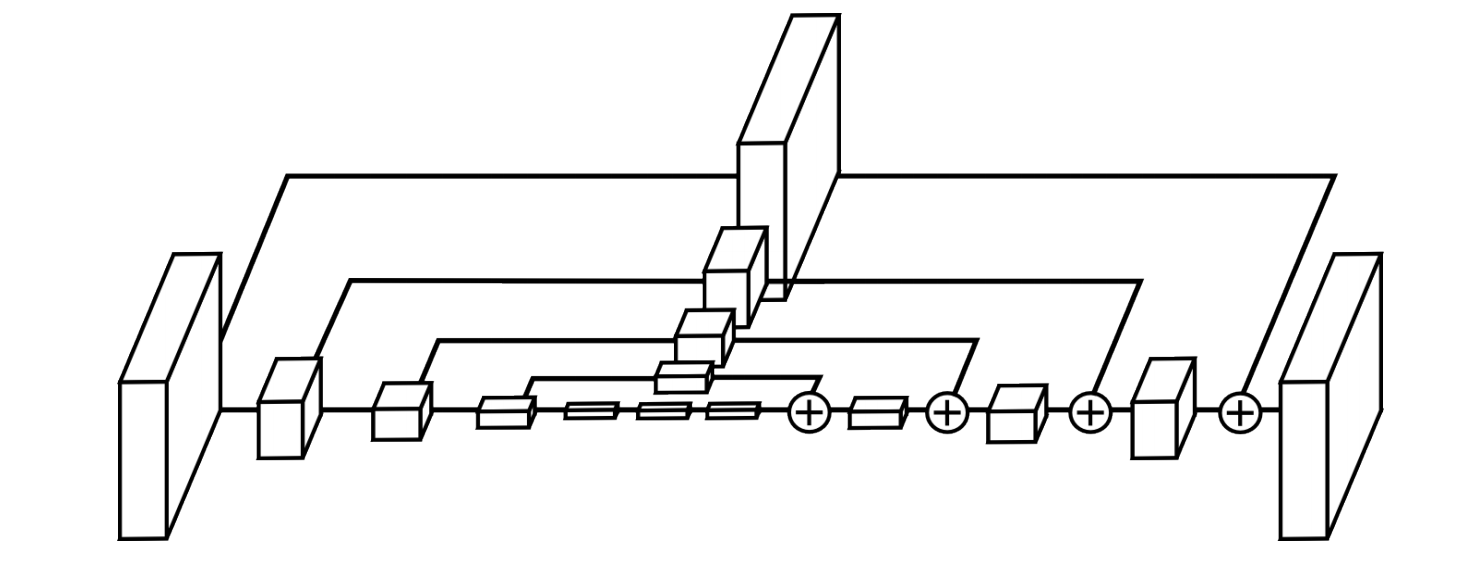

In [10]:
class Hourglass(nn.Module):
    def __init__(self,n,f,bn=None,increase=0):
        super(Hourglass,self).__init__()
        #n:encoder + decoderを重ねる回数
        #f:特徴マップの数
        #increase:1つ深いencoder+decoderへの入力に対して、特徴マップに幾つ増やすか

        nf = f + increase
        #Upper branch
        self.up1 = Residual(f,f)
        #Lower branch
        self.pool1 = nn.MaxPool2d(2,2)
        self.low1 = Residual(f,nf)
        self.n = n
        #Recursive hourglass
        if self.n > 1:
            self.low2 = Hourglass(n-1,nf,bn = bn)
        else:
            self.low2 = Residual(nf,nf)
        self.low3 = Residual(nf,f)
        self.up2 = nn.Upsample(scale_facter=2,mode="nearest")

    def forward(self,x):
        up1 = self.up1(x)
        pool1 = self.pool1(x)
        low1 = self.low1(pool1)
        low2 = self.low2(low1)
        low3 = self.low3(low2)
        up2 = self.up2(low3)
        return up1 + up2

### 1-4 PoseNetクラスの定義

1-3で定義したHourglassクラスを中心として多層に積み重ねることで、Stacked Hourglass Networks全体をPoseNetクラスとして定義する。

Hourglass Network同士の接続は下図の様に行われる。

下図の砂時計はHourglass Netowork, 長方形は特徴マップを表しており、Hourglass Networkの外の各特長マップ間は1x1の畳み込み演算が行われる（例外あり）。

また、下図の青い長方形はヒートマップ出力を表しており、Stacked Hourglass Network全体から見ると途中の層ではあるが、このヒートマップ出力も学習に用いるLoss関数に加えることで精度向上が可能となる。

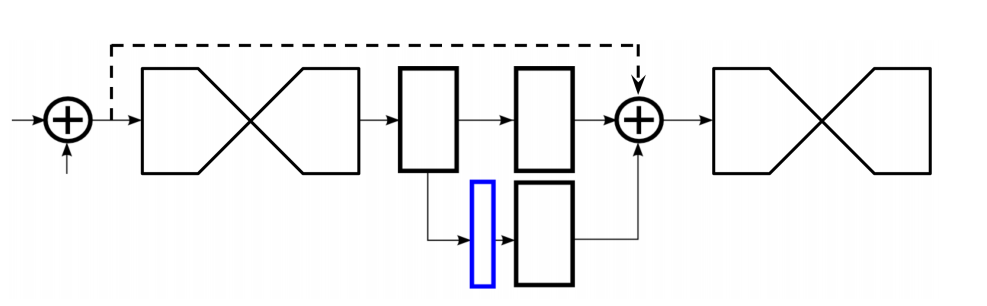

In [11]:
#特徴マップの数を揃えるための1x1Convを定義するクラス
class Merge(nn.Module):
    def __init__(self,x_dim,y_dim):
        super(Merge,self).__init__()
        self.conv = Conv(x_dim,y_dim1,relu=False,bn=False)
    
    def forward(self,x):
        return sef.conv(x)

In [12]:
# 特徴マップの数をそろえるための1x1 Convを定義するクラス
class Merge(nn.Module):
    def __init__(self, x_dim, y_dim):
        super(Merge, self).__init__()
        self.conv = Conv(x_dim, y_dim, 1, relu=False, bn=False)

    def forward(self, x):
        return self.conv(x)
    
class PoseNet(nn.Module):
    def __init__(self, nstack, inp_dim, oup_dim, bn=False, increase=0, **kwargs):
        super(PoseNet, self).__init__()
        # nstack:hourglass networkを重ねる数
        # inp_dim:hourglass networkへの入力の特徴マップ数
        # oup_dim:ヒートマップの数（=キーポイントの数）
        
        self.nstack = nstack
        self.pre = nn.Sequential(
            Conv(3, 64, 7, 2, bn=True, relu=True),
            Residual(64, 128),
            nn.MaxPool2d(2, 2),
            Residual(128, 128),
            Residual(128, inp_dim)
        ) # 最初に256から64に圧縮する
        
        self.hgs = nn.ModuleList( [
        nn.Sequential(
            Hourglass(4, inp_dim, bn, increase),
        ) for i in range(nstack)] ) # hourglassを指定の数だけ用意
        
        self.features = nn.ModuleList( [
        nn.Sequential(
            Residual(inp_dim, inp_dim),
            Conv(inp_dim, inp_dim, 1, bn=True, relu=True)
        ) for i in range(nstack)] ) # hourglassの出力に対する演算を行う層
        
        # ヒートマップを出力する層
        self.outs = nn.ModuleList( [Conv(inp_dim, oup_dim, 1, relu=False, bn=False) for i in range(nstack)] )
        
        # 最後にself.featureとself.out, さらにskip connectionを足し合わせるために特徴マップ数をそろえるための層
        # merge layerは1×1のconv層である
        self.merge_features = nn.ModuleList( [Merge(inp_dim, inp_dim) for i in range(nstack-1)] )
        self.merge_preds = nn.ModuleList( [Merge(oup_dim, inp_dim) for i in range(nstack-1)] )
        
        self.nstack = nstack

    def forward(self, imgs):
        ## our posenet
        x = imgs.permute(0, 3, 1, 2) #x of size 1,3,inpdim,inpdim
        x = self.pre(x) # 画像サイズを256から64に下げる
        combined_hm_preds = [] # 各hourglassの出力を格納
        for i in range(self.nstack):
            hg = self.hgs[i](x) # hgsのi番目のlayerに入力
            feature = self.features[i](hg) 
            preds = self.outs[i](feature) # i番目のlayerの予測値(ヒートマップ)
            combined_hm_preds.append(preds) 
            if i < self.nstack - 1: 
                # 足し算を行い次のlayerの入力を用意
                x = x + self.merge_preds[i](preds) + self.merge_features[i](feature)

        return torch.stack(combined_hm_preds, 1) # (batch, nstack, key_point, 縦, 横)


#Loss関数の設計